# *Image processing of corroded pit - part 3: data visualization and plotting*

- By [Gianluca Iori](https://github.com/gianthk), Giulia Franceschin, Roberta Zanin, Elena Longo, 2022
- Code licence: MIT
- Narrative licence: CC-BY 
- How to cite: *Specify how you want people to cite this notebook. You can refer to a publication or a repository (e.g. link your GitHub repository to Zenodo - see [this video](https://www.youtube.com/watch?v=gp3D4mf6MHQ))*
- Created on:  21.02.2023
- Last update: 21.02.2023

---
# Aims

1. Particle localization
    - [X] particles / voids VS pit front
    - [X] hist distance from voids
2. Particle size and shape
    - [X] hist volume
    - [X] hist sphericity
    - [X] hist DA
    - [X] shell mesh single particle with symmetry plane and principal eigenvector (paraview)
3. Particle orientation
    - [X] orientation plot SPAM
    
---
## Figures
- [X] Overview 3D front; top; side (white BG)
- [X] pit region zoom
- [X] pit XY slice with highlights
    - [X] particles
    - [X] pit front
- [X] particles location, size, shape
- [X] particles orientation
- [X] surface corrosion layer with particles

![plotting](plotting.jpeg)

---
# *Computational workflow*

## Configuration and imports

In [2]:
import sys
sys.path.append('./../../recon_utils')
sys.path.append('./../../../recon_utils')

Configure working folder (change this to your local path)

In [3]:
work_folder = "/run/media/beats/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt"
# work_folder = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'
# work_folder = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt'
res_folder = "./../results"

In [4]:
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt
import meshio
import h5py

from scipy import ndimage, stats # , misc
from skimage import morphology #, measure

from recon_utils import read_tiff_stack, plot_midplanes
# from pybonemorph import remove_unconnected, remove_largest

import spam.mesh
import spam.label
import spam.plotting
import spam.datasets

astropy module not found
olefile module not found


Matplotlib plotting configuration

In [22]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

Use Matplotlib's dark background

In [6]:
plt.style.use('dark_background')

## Load results file
### Load HDF5 dataset file

In [7]:
res_file = res_folder+"/581681_punta_HR_stitch2_crystals_results_230221.hdf5"
f = h5py.File(res_file, 'r')

Voxelsize:

In [8]:
vs = np.ones(3)*1.0e-3 # [mm]

The `h5py` call used to save the results file:
```python
with h5py.File(res_folder+"/581681_punta_HR_stitch2_crystals_results_230221.hdf5", "w") as f:
    g_spam = f.create_group("spam")
    g_spam.create_dataset("volume", data=pearl_volume, dtype='uint32', compression="gzip")
    g_spam.create_dataset("sphericity", data=sphericity.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("MOIeigenValues", data=MOIeigenValues.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("MOIeigenVectors", data=MOIeigenVectors.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("DA", data=DA.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("centresOfMass", data=centresOfMass.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("projection_theta_r", data=projection_theta_r.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("theta", data=theta.astype('float16'), dtype='float16', compression="gzip")
    
    g_location = f.create_group("particle_location")
    g_location.create_dataset("dist_particle-pitfront", data=distances_pit_bottom.astype('float16'), dtype='float16', compression="gzip")
    g_location.create_dataset("dist_particle-void", data=distances_voids.astype('float16'), dtype='float16', compression="gzip")
    g_location.create_dataset("dist_void-pitfront", data=voids_dist_front.astype('float16'), dtype='float16', compression="gzip")
```

Read single results datasets

In [9]:
volume = f['spam']['volume']
sphericity = f['spam']['sphericity']
DA = f['spam']['DA']
projection_theta_r = f['spam']['projection_theta_r']
theta = f['spam']['theta']
MOIeigenVectors = f['spam']['MOIeigenVectors']

dist_particle_pitfront = f['particle_location']['dist_particle-pitfront']
dist_particle_void = f['particle_location']['dist_particle-void']
dist_void_pitfront = f['particle_location']['dist_void-pitfront']

In [10]:
print(dist_particle_pitfront.shape)
print(dist_particle_void.shape)
print(dist_void_pitfront.shape)
print(volume.shape)

(77574,)
(77574,)
(153059197,)
(77574,)


## Particles size and shape

In [20]:
matplotlib.rcParams['figure.figsize'] = 5,6

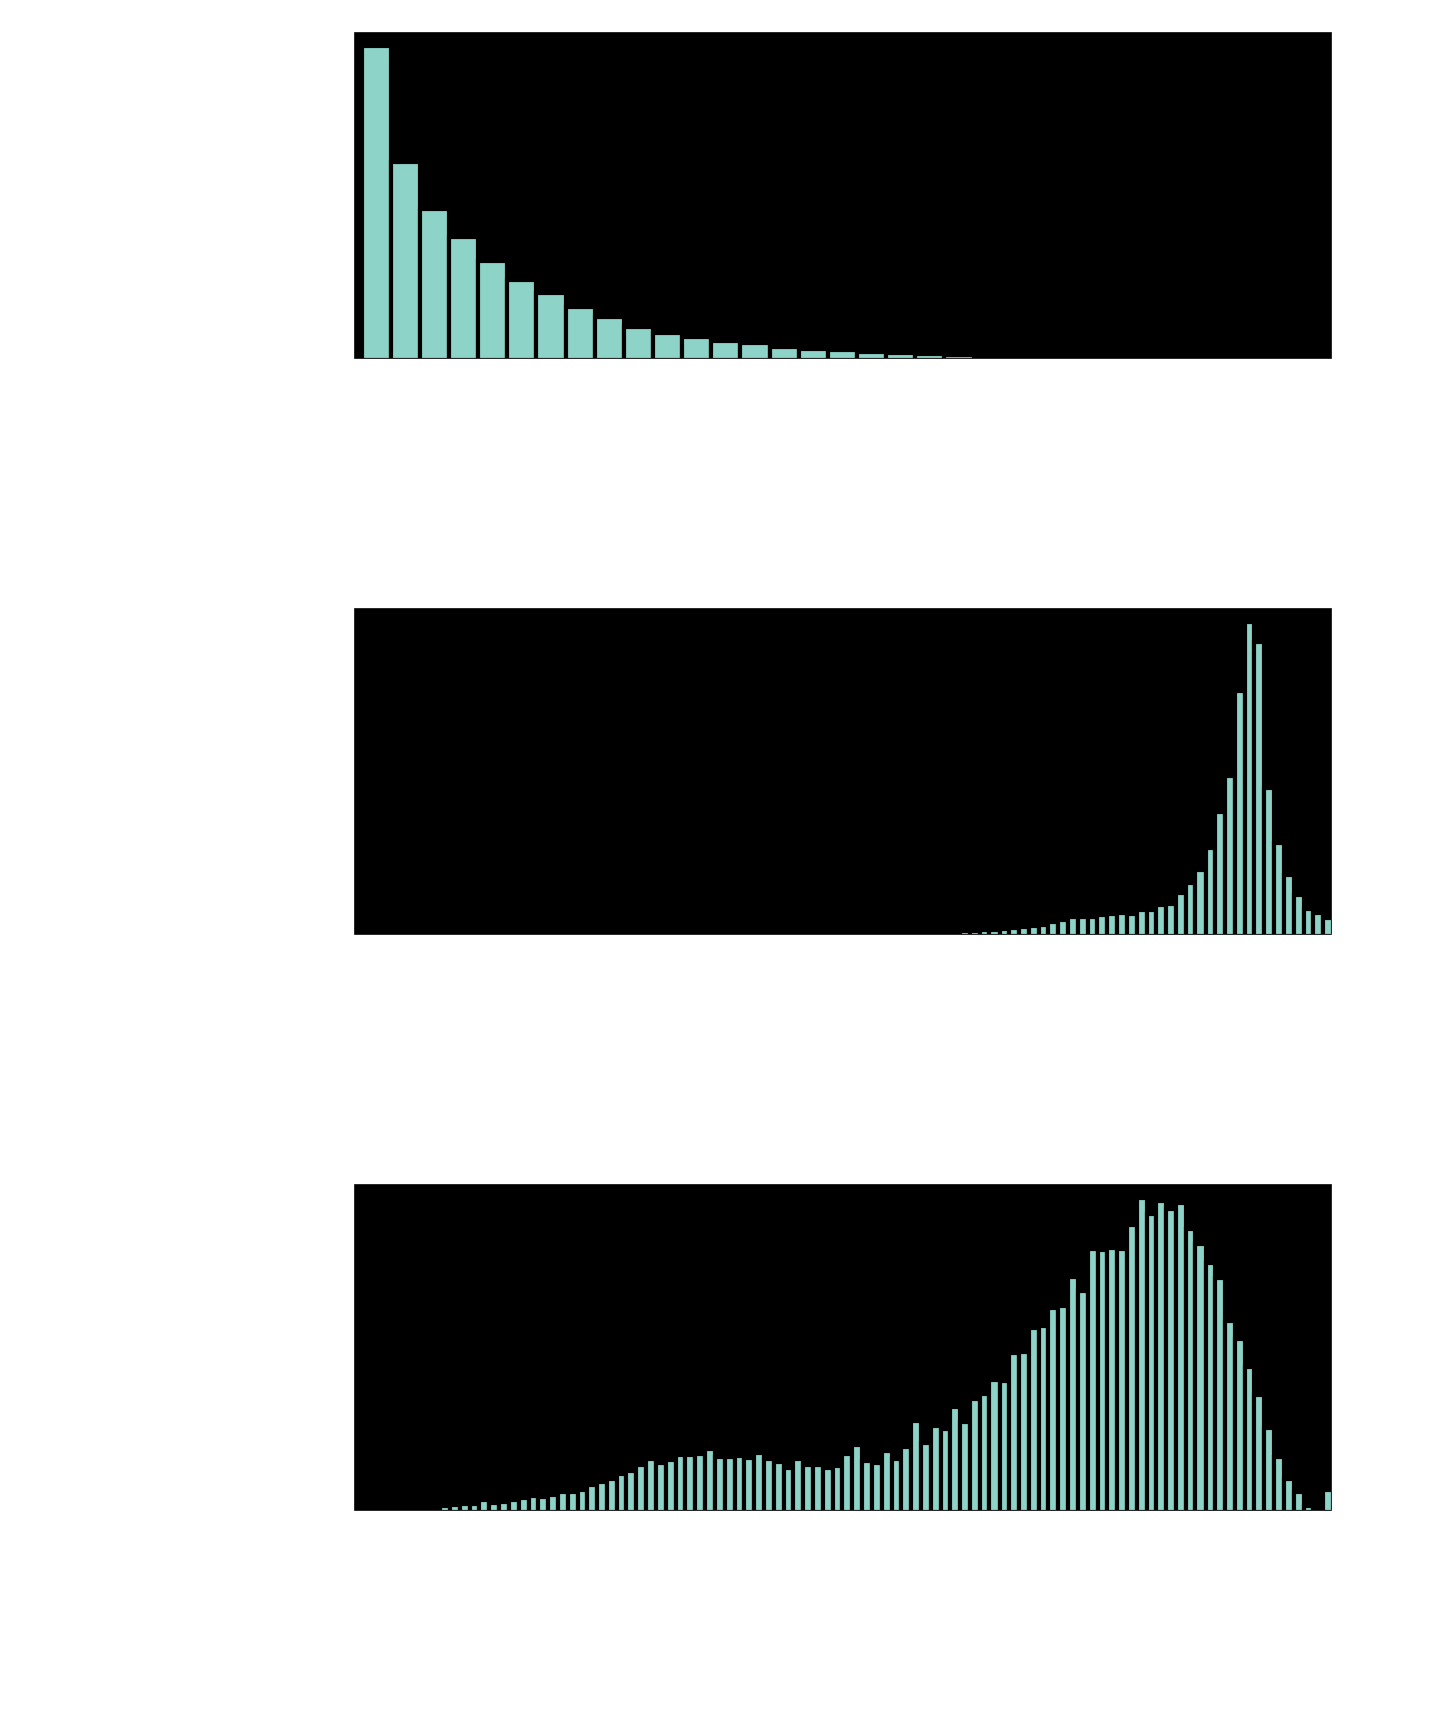

In [23]:
bins = 100
fig, axs = plt.subplots(3)
axs[0].hist(volume[(volume[:]>100) & (volume[:]<30e3)], bins=bins, edgecolor="k")
# axs[0].xticks(np.arange(0, 650, 50))
axs[0].set_xlim(0, 10000)
axs[1].hist(sphericity[sphericity[:]<=1], bins=bins, edgecolor="k")
axs[1].set_xlim(0, 1)
axs[2].hist(DA, bins=bins, edgecolor="k")
axs[2].set_xlim(0, 1)
axs[0].set_xlabel("Volume (voxels)")
axs[0].set_ylabel("Counts")
axs[1].set_xlabel("Sphericity")
axs[1].set_ylabel("Counts")
axs[2].set_xlabel("Degree of anisotropy")
axs[2].set_ylabel("Counts")
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.tight_layout()
fig.savefig(res_folder+'/volume_sphericity_DA.png')

### Plot particle volume (or sphericity) VS distance from corrosion front
> Do the deposits change in volume and shape with age?

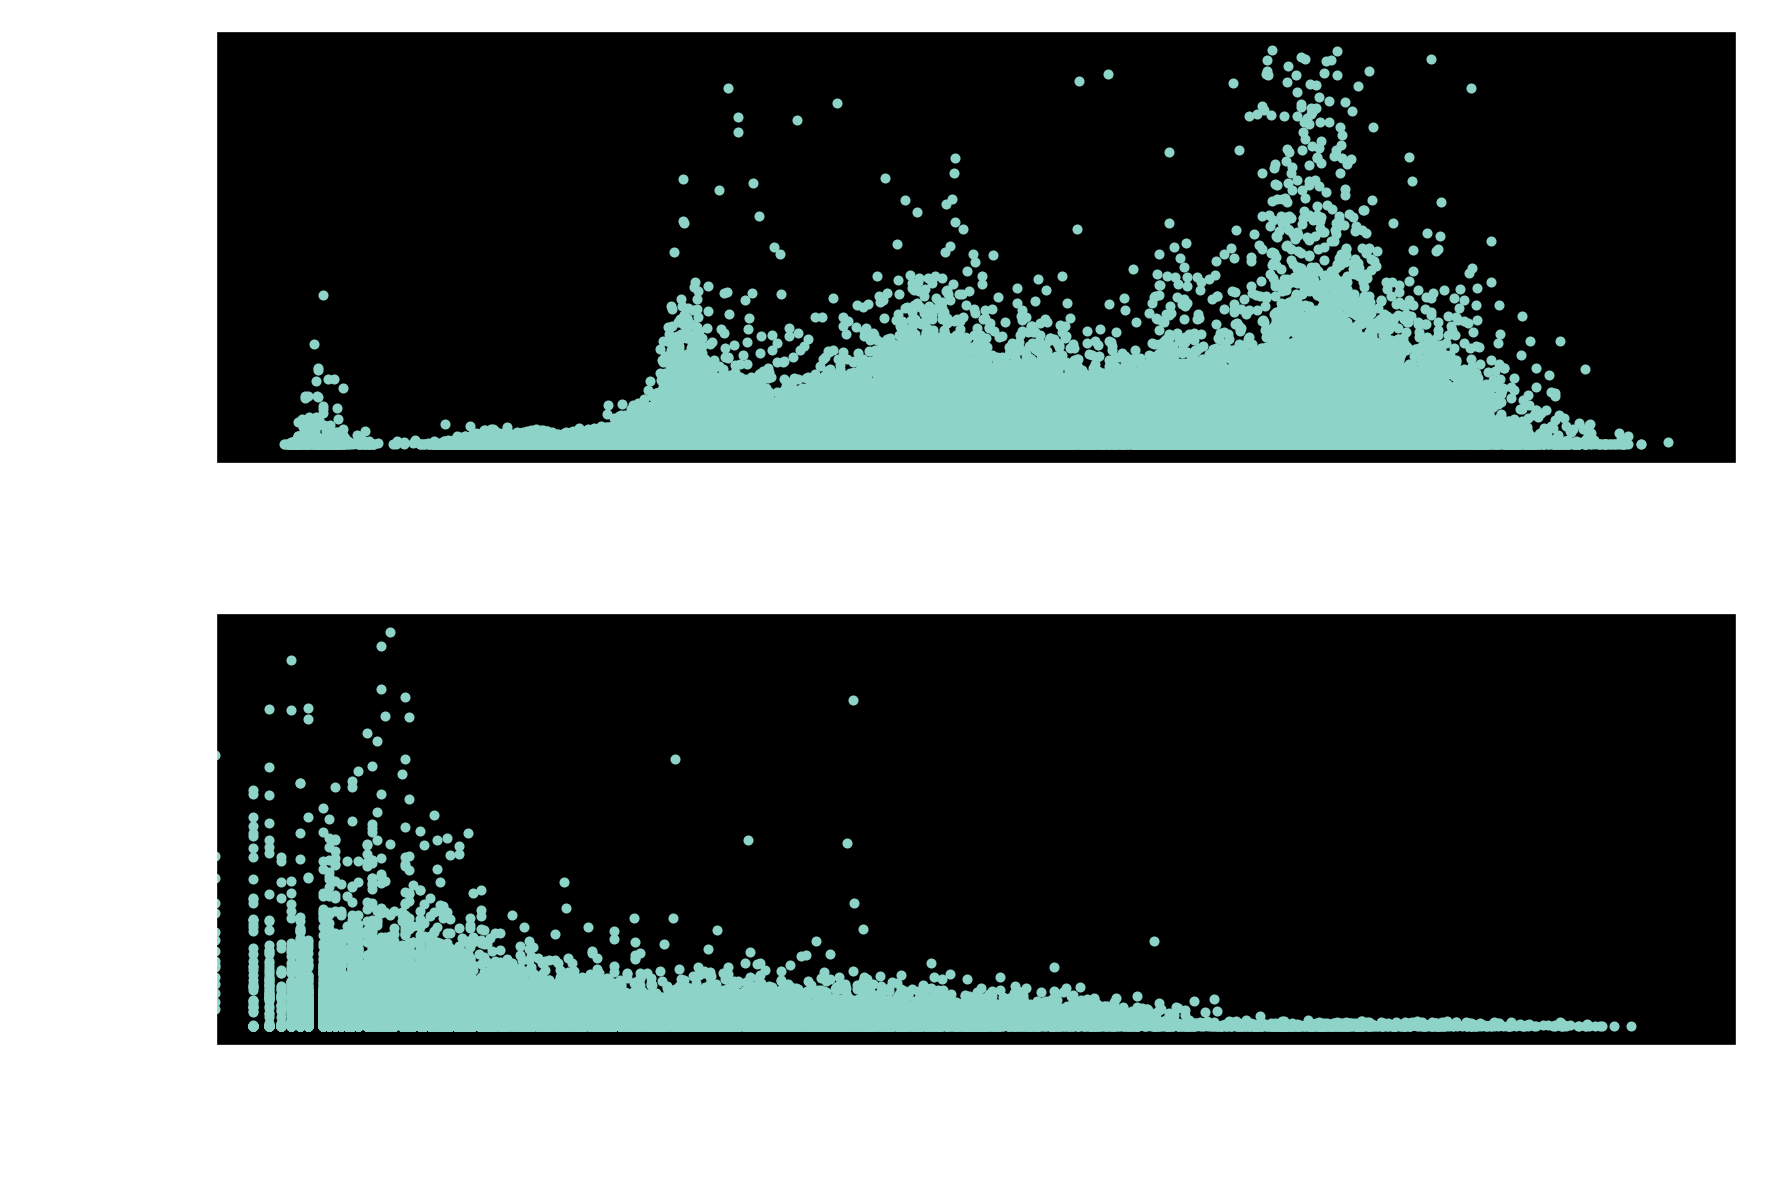

In [26]:
fig, axs = plt.subplots(2)
axs[0].scatter(dist_particle_pitfront[volume[:]<30e3], volume[volume[:]<30e3], s=2)
axs[0].set_xlabel("Distance from corrosion front [um]")
axs[0].set_ylabel("Particle volume [voxels]")
axs[1].scatter(dist_particle_void[volume[:]<60e3], volume[volume[:]<60e3], s=2)
axs[1].set_xlim(0, 80)
axs[1].set_xlabel("Distance from a void [um]")
axs[1].set_ylabel("Particle volume [voxels]")
fig.tight_layout()

## Particle location
Plot distance of particles from pit corrosion front and from voids within the pit

In [24]:
kde = stats.gaussian_kde(dist_particle_pitfront[:])
x = np.linspace(dist_particle_pitfront[:].min(), dist_particle_pitfront[:].max(), 400)
p = kde(x)

In [25]:
kde2 = stats.gaussian_kde(dist_void_pitfront[:])
x2 = np.linspace(dist_void_pitfront[:].min(), dist_void_pitfront[:].max(), 400)
p2 = kde2(x2)

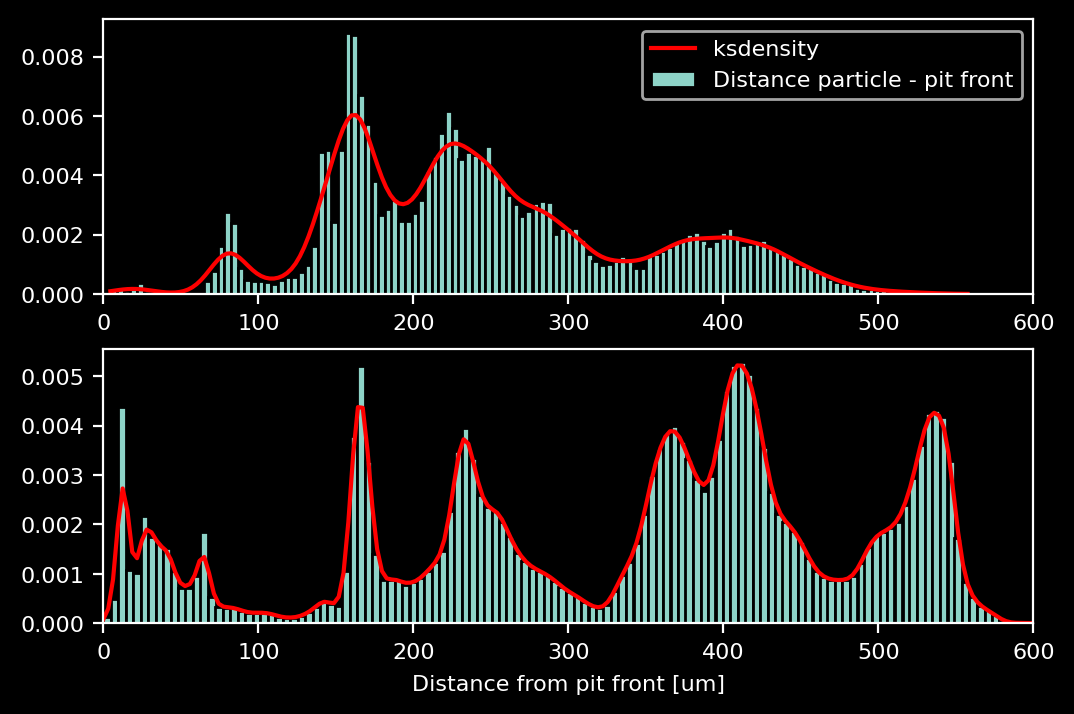

In [60]:
fig, axs = plt.subplots(2)
axs[0].hist(dist_particle_pitfront[:], bins=128, edgecolor="k", density=True, label='Distance particle - pit front')
axs[0].plot(x, p, 'r', label='ksdensity')
axs[0].set_xlim(0, 600)
axs[1].hist(dist_void_pitfront[:], bins=128, edgecolor="k", density=True, label='Distance voids - pit front')
axs[1].plot(x2, p2, 'r', label='ksdensity')
axs[1].set_xlim(0, 600)
axs[1].set_xlabel("Distance from pit front [um]")
# axs[0].set_ylabel("Density")
# axs[1].set_ylabel("Density")
axs[0].legend()

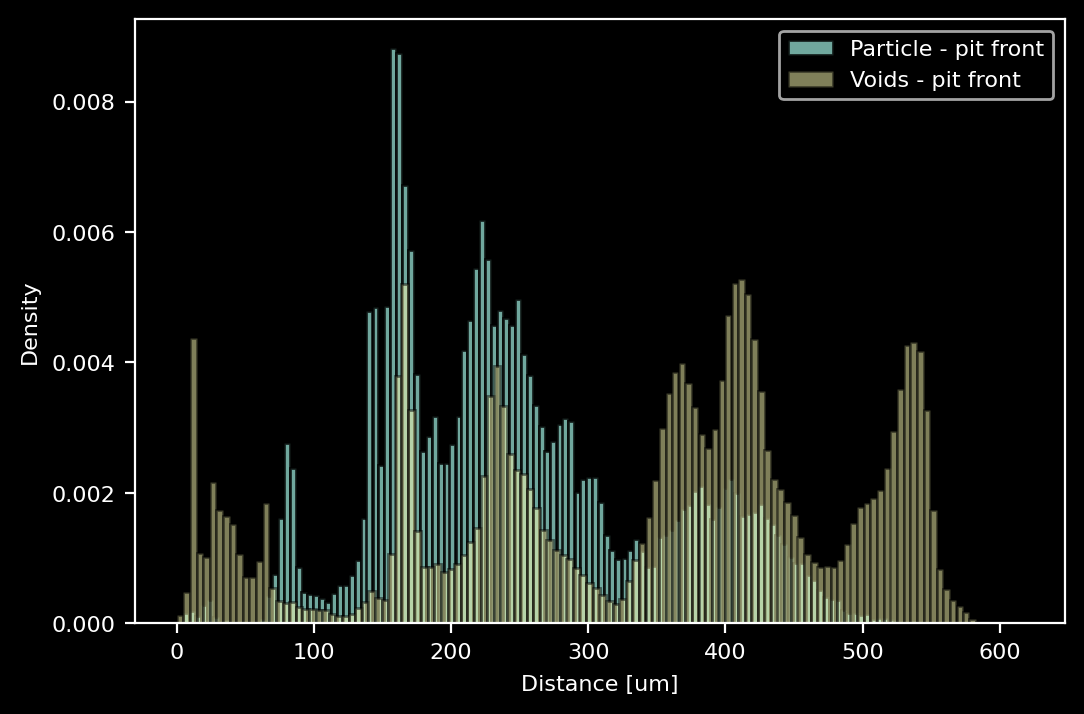

In [70]:
plt.figure()
plt.hist(dist_particle_pitfront[:], bins=128, edgecolor="k", alpha=0.8, density=True, label='Particle - pit front')
plt.hist(dist_void_pitfront[:], bins=128, edgecolor="k", alpha=0.5, density=True, label='Voids - pit front')
plt.xlabel("Distance [um]")
plt.ylabel("Density")
plt.legend()

In [59]:
matplotlib.rcParams['figure.figsize'] = 7.8,4

In [41]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

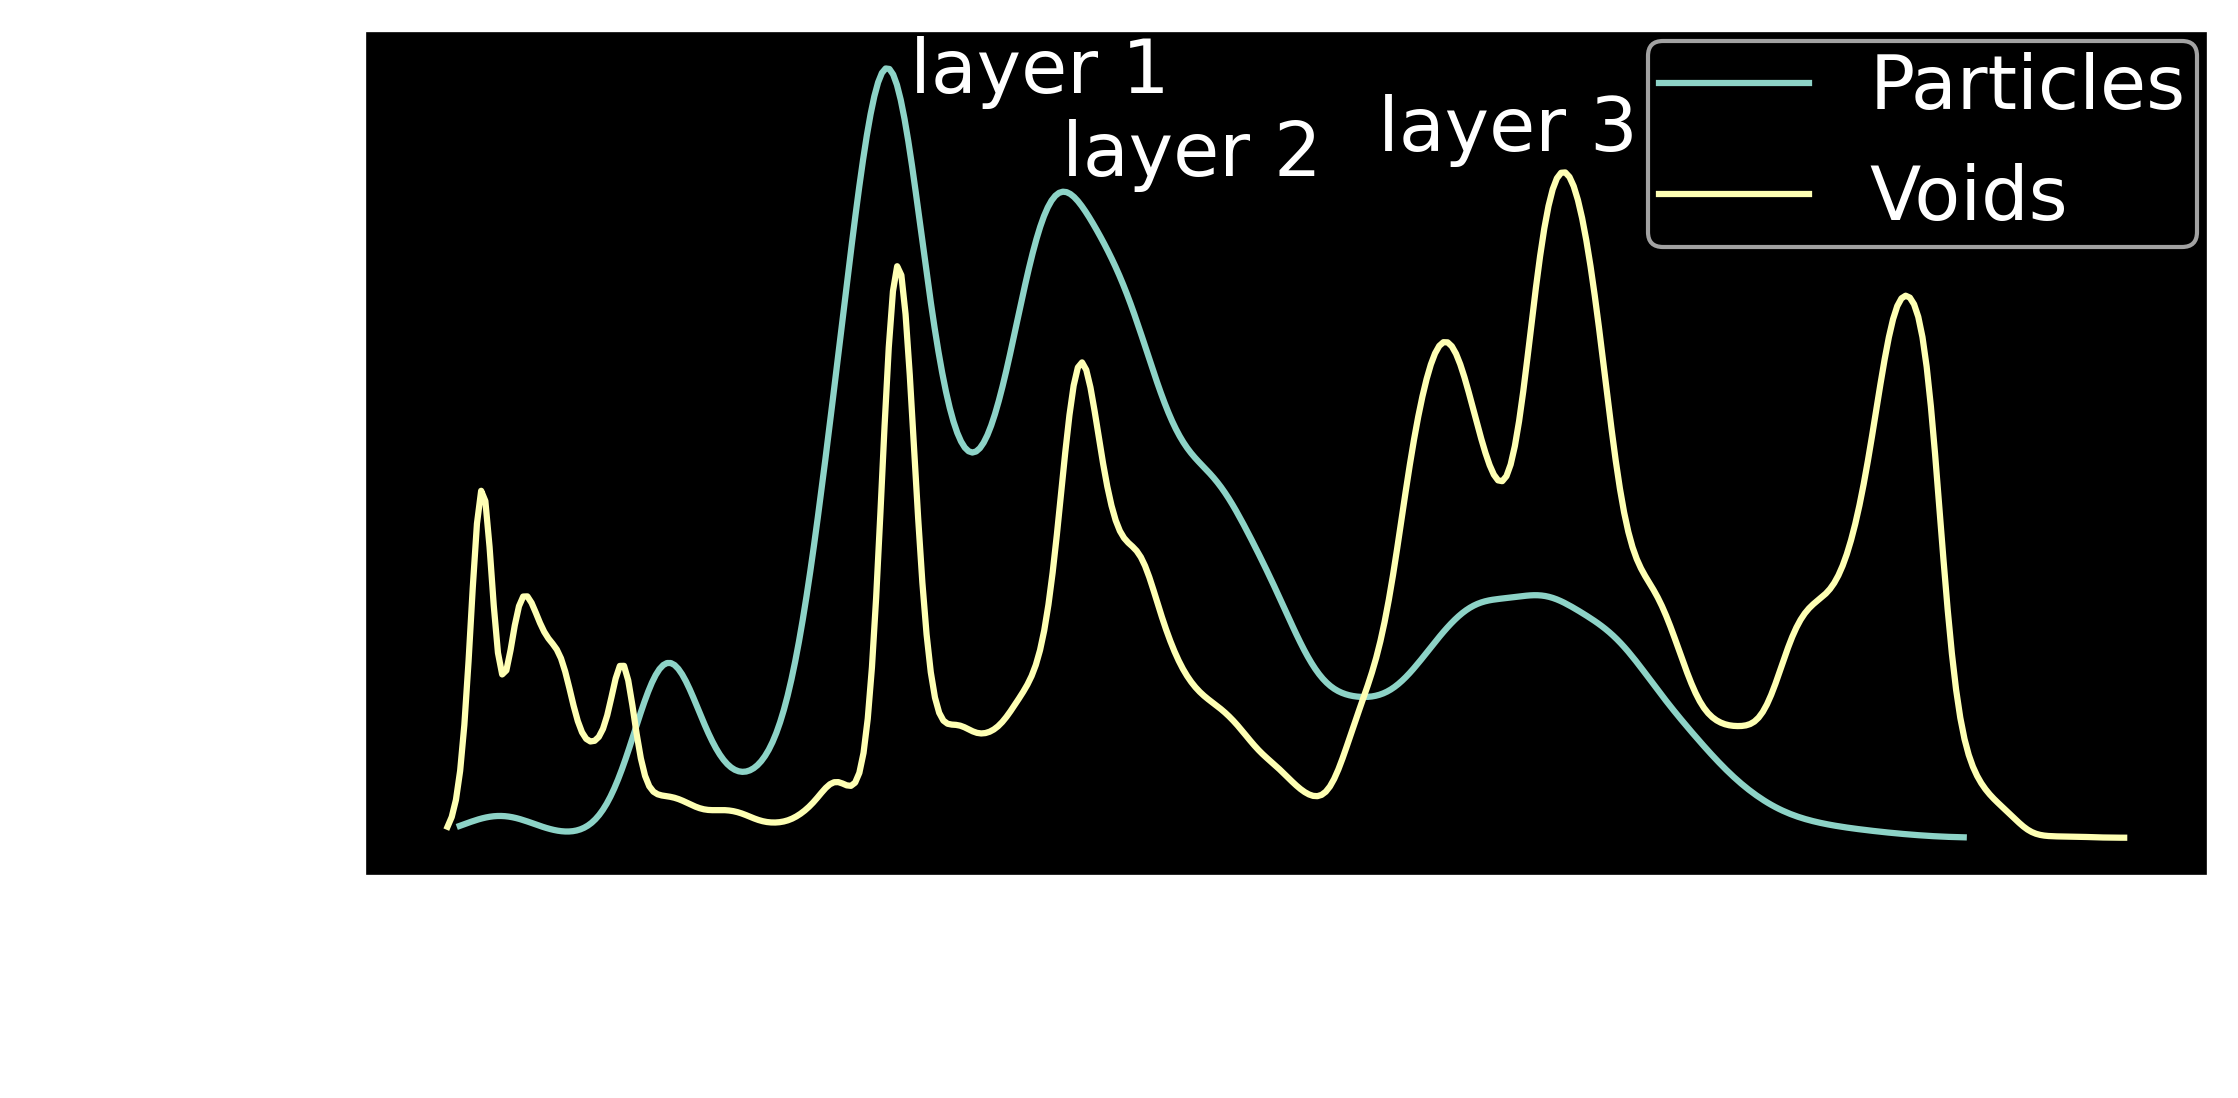

In [63]:
fig, axs = plt.subplots()
plt.plot(x, p, label='Particles')
plt.plot(x2, p2, label='Voids')
plt.xticks(np.arange(0, 650, 100))
# plt.grid(axis='x')
plt.xlabel("Distance to alteration front [\u03BCm]")
plt.ylabel("Density function")
plt.legend(loc='upper right', borderpad=0.15, borderaxespad=0.15)
plt.annotate('layer 1', [170, 0.00585])
plt.annotate('layer 2', [226, 0.0052])
plt.annotate('layer 3', [342, 0.0054])
fig.tight_layout()
fig.savefig(res_folder+'/dist_pitfront.png')

> *Particles are colocalized with voids within the pit*

#### Plot histogram and Cumulative Density Function (CFD) of the particle distance from corrosion front

In [64]:
n_bins = 256
h, bins = np.histogram(dist_particle_void[:], bins=n_bins)

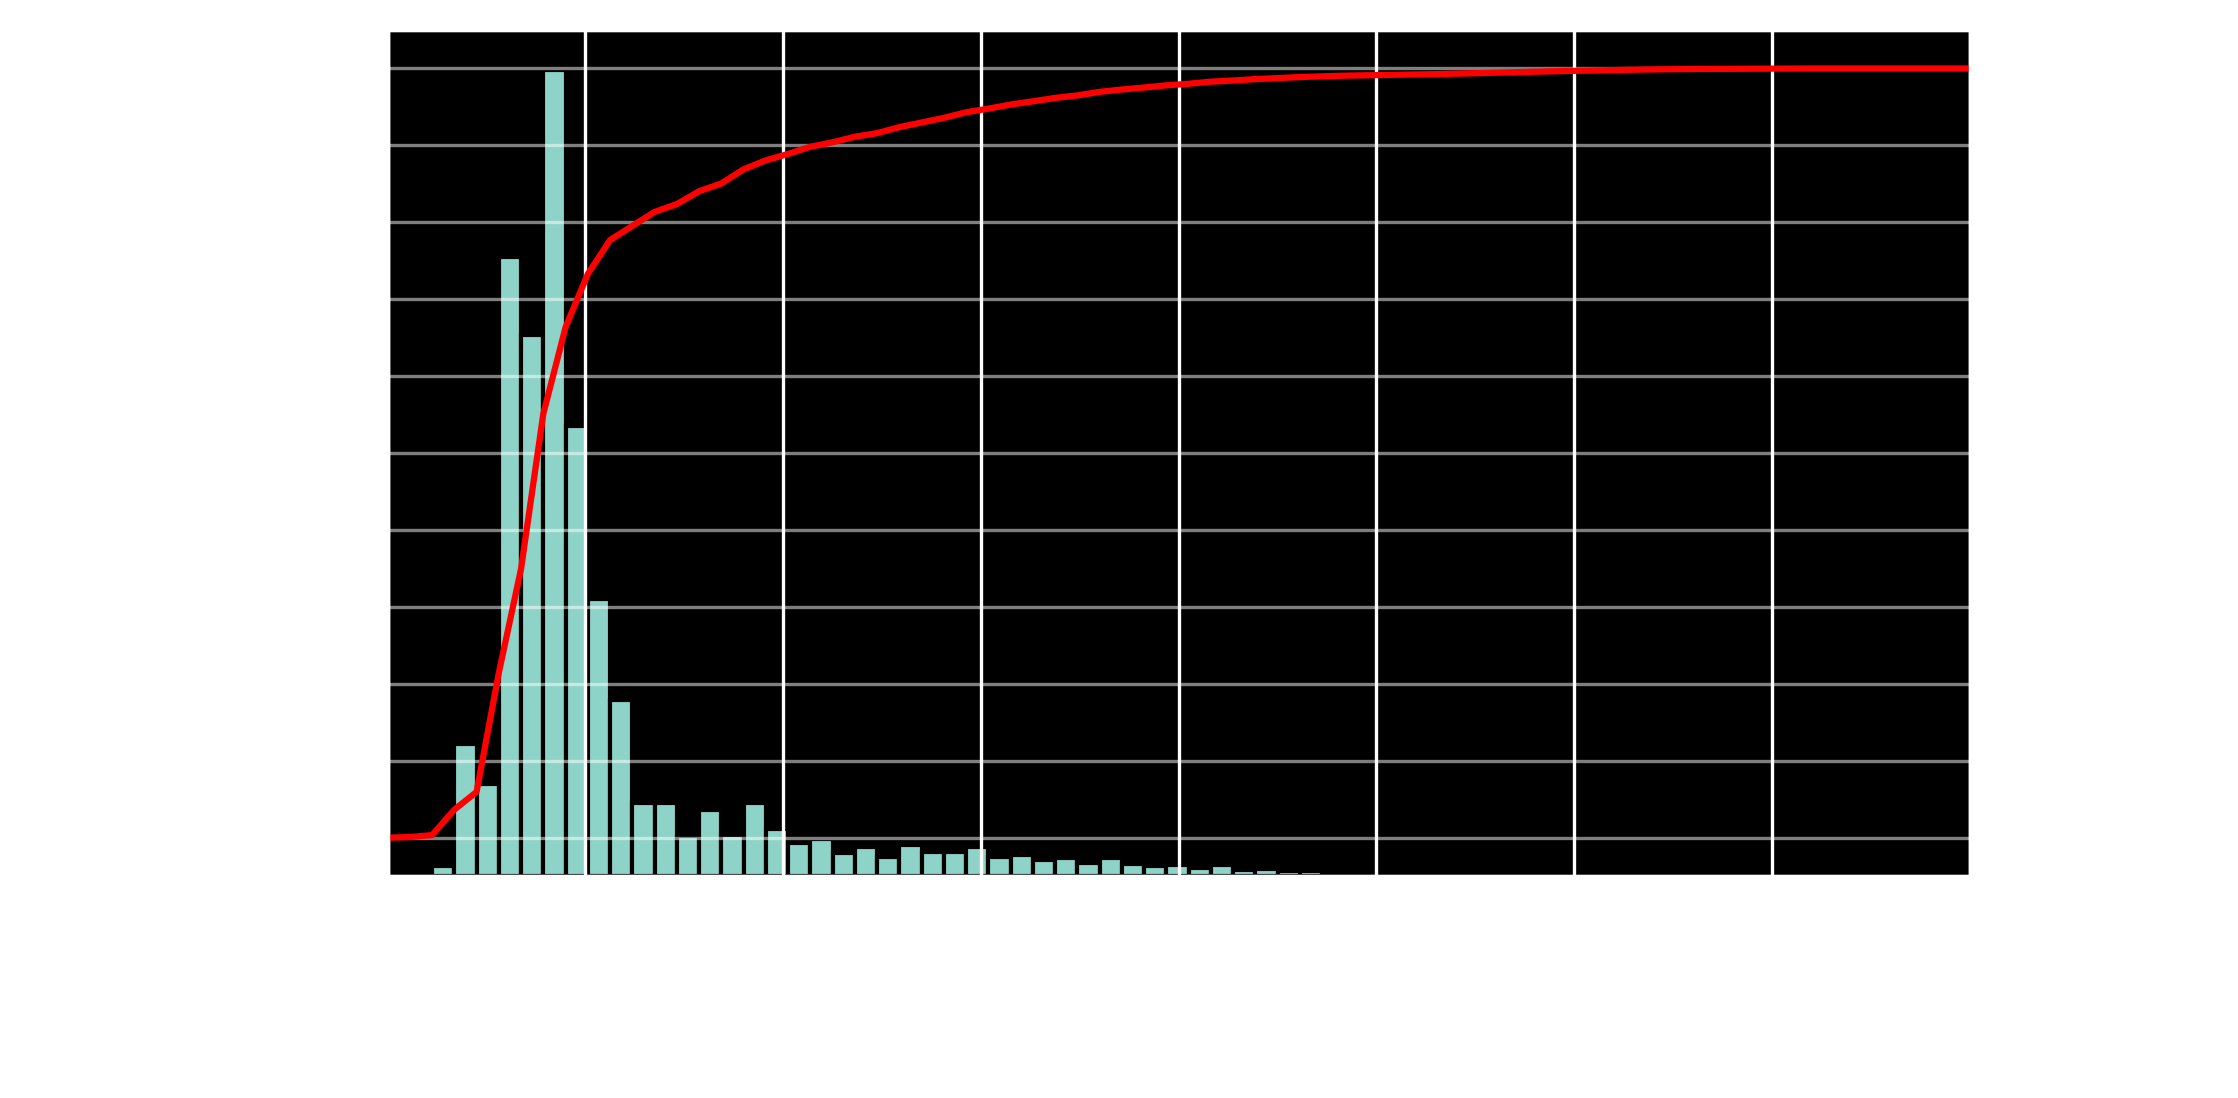

In [69]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.hist(dist_particle_void[:], bins=n_bins, edgecolor="k", label='Distance particle - void') # density=True, alpha=1, 
ax1.plot(bins[:-1], np.cumsum(h)/np.max(np.cumsum(h)), 'r')
ax.set_xlabel("Distance to voids [\u03BCm]")
ax.set_xticks(np.arange(0, 100, 10))
ax.set_xlim(0, 80)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("Counts")
ax1.set_ylabel('Cumulative density')
ax1.grid(which='both', alpha=0.5)
ax.grid(axis='x')
fig.tight_layout()
fig.savefig(res_folder+'/dist_histogram.png')

> *90% of the particles are within 20 micron from a void region*

## Particles orientation
We have calculated the `Moments of Inertia` using the corresponding method of the `spam.label` toolkit.

Plot particle orientation: display the 3D orientation of the major axes of each particle.

In [70]:
cmap = matplotlib.colormaps['viridis']

In [80]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

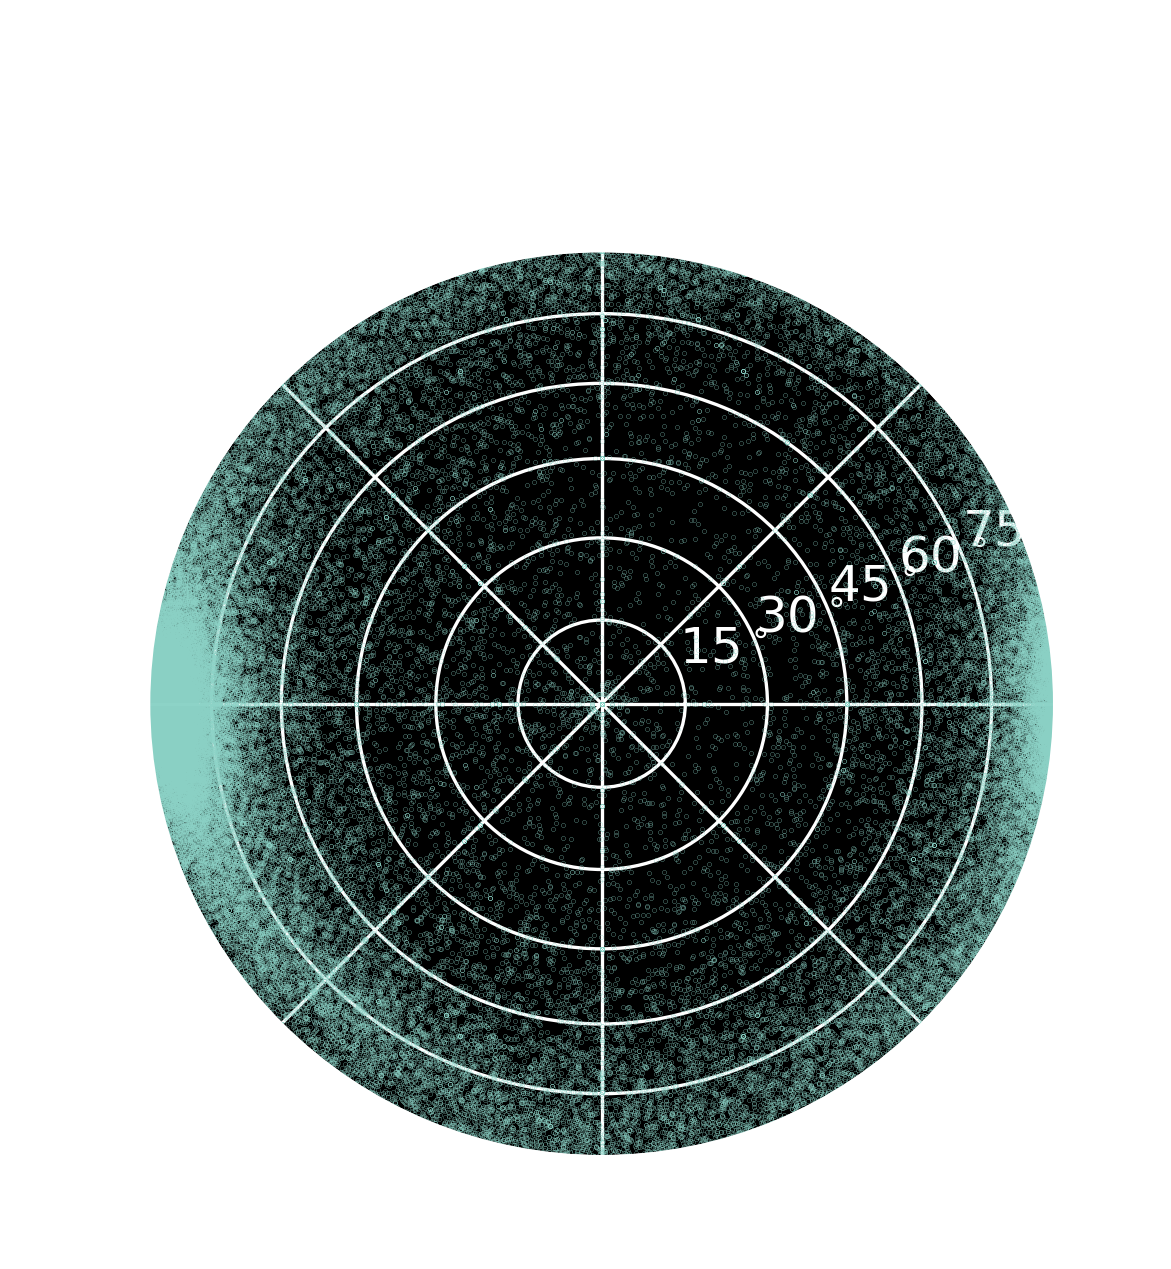

In [81]:
spam.plotting.orientationPlotter.plotOrientations(MOIeigenVectors[np.where(MOIeigenVectors[:, 0:3].any(axis=1))[0], 0:3], plot='points', numberOfRings=5, pointMarkerSize=0.15, cmap=cmap, saveFigPath=res_folder+'/evec1_orientation_XY.png') # evec 1 #

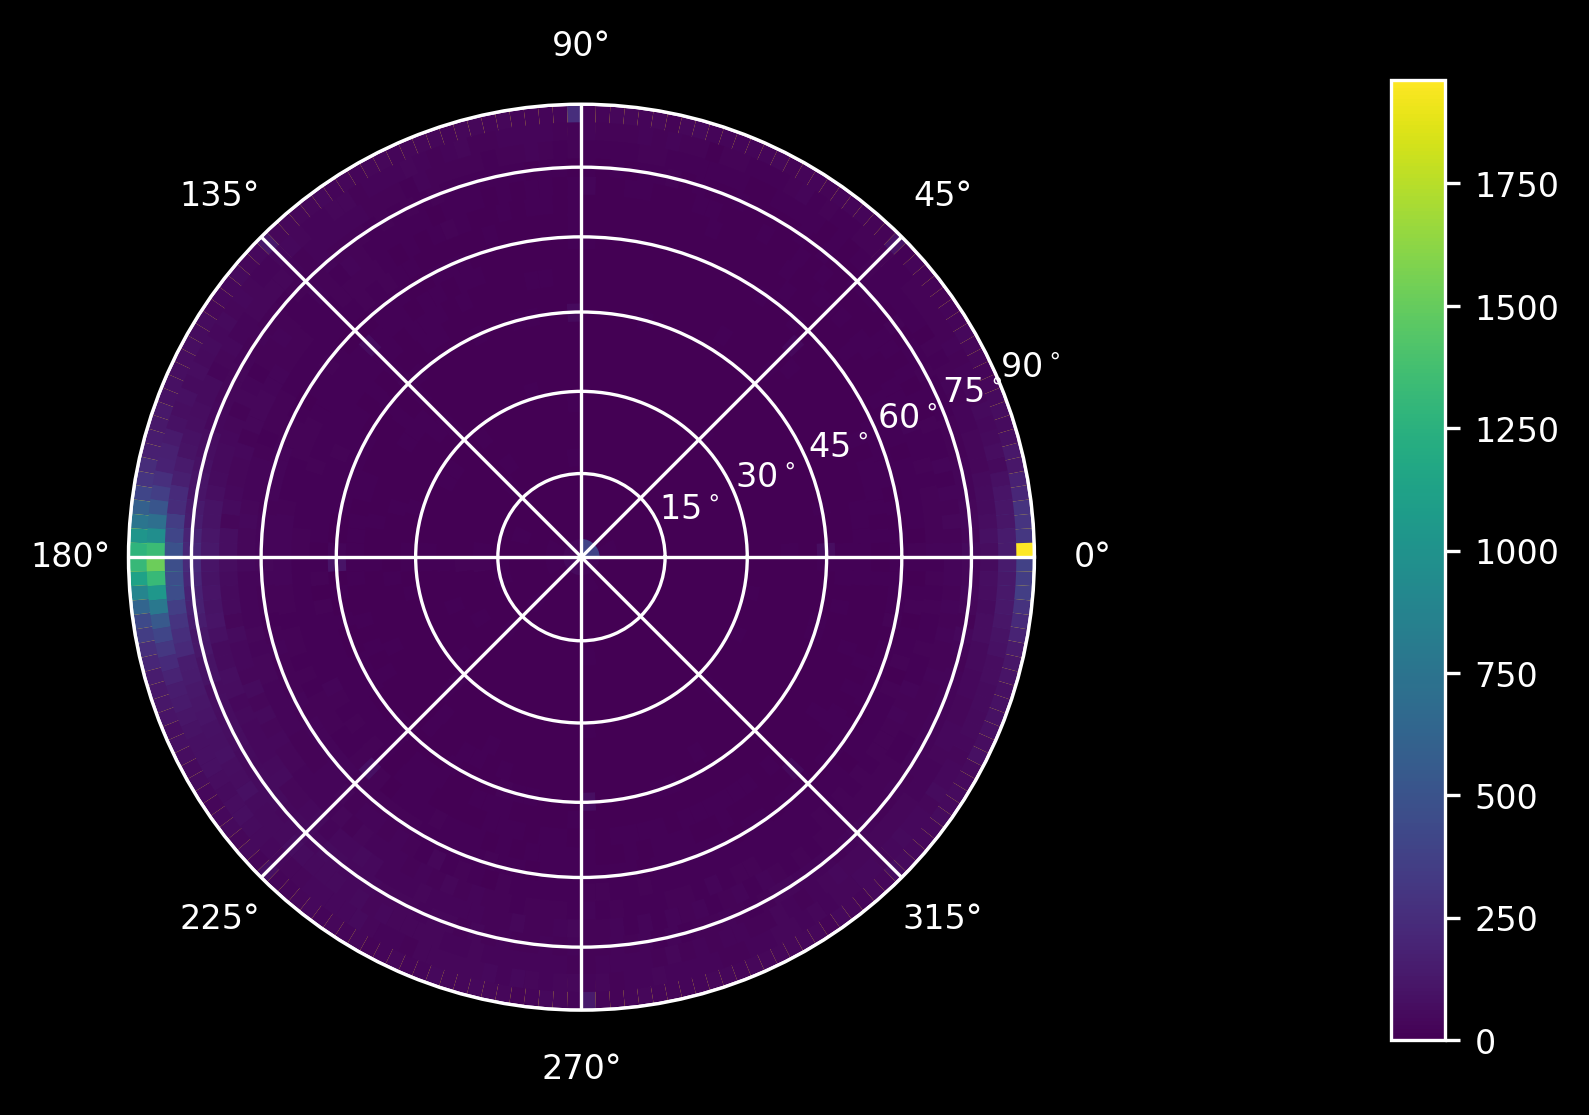

In [90]:
spam.plotting.orientationPlotter.plotOrientations(MOIeigenVectors[np.where(MOIeigenVectors[:, 0:3].any(axis=1))[0], 0:3], plot='bins', numberOfRings=25, pointMarkerSize=0.1, cmap=cmap, saveFigPath=res_folder+'/evec1_orientation_XY_bins.png') # evec 1

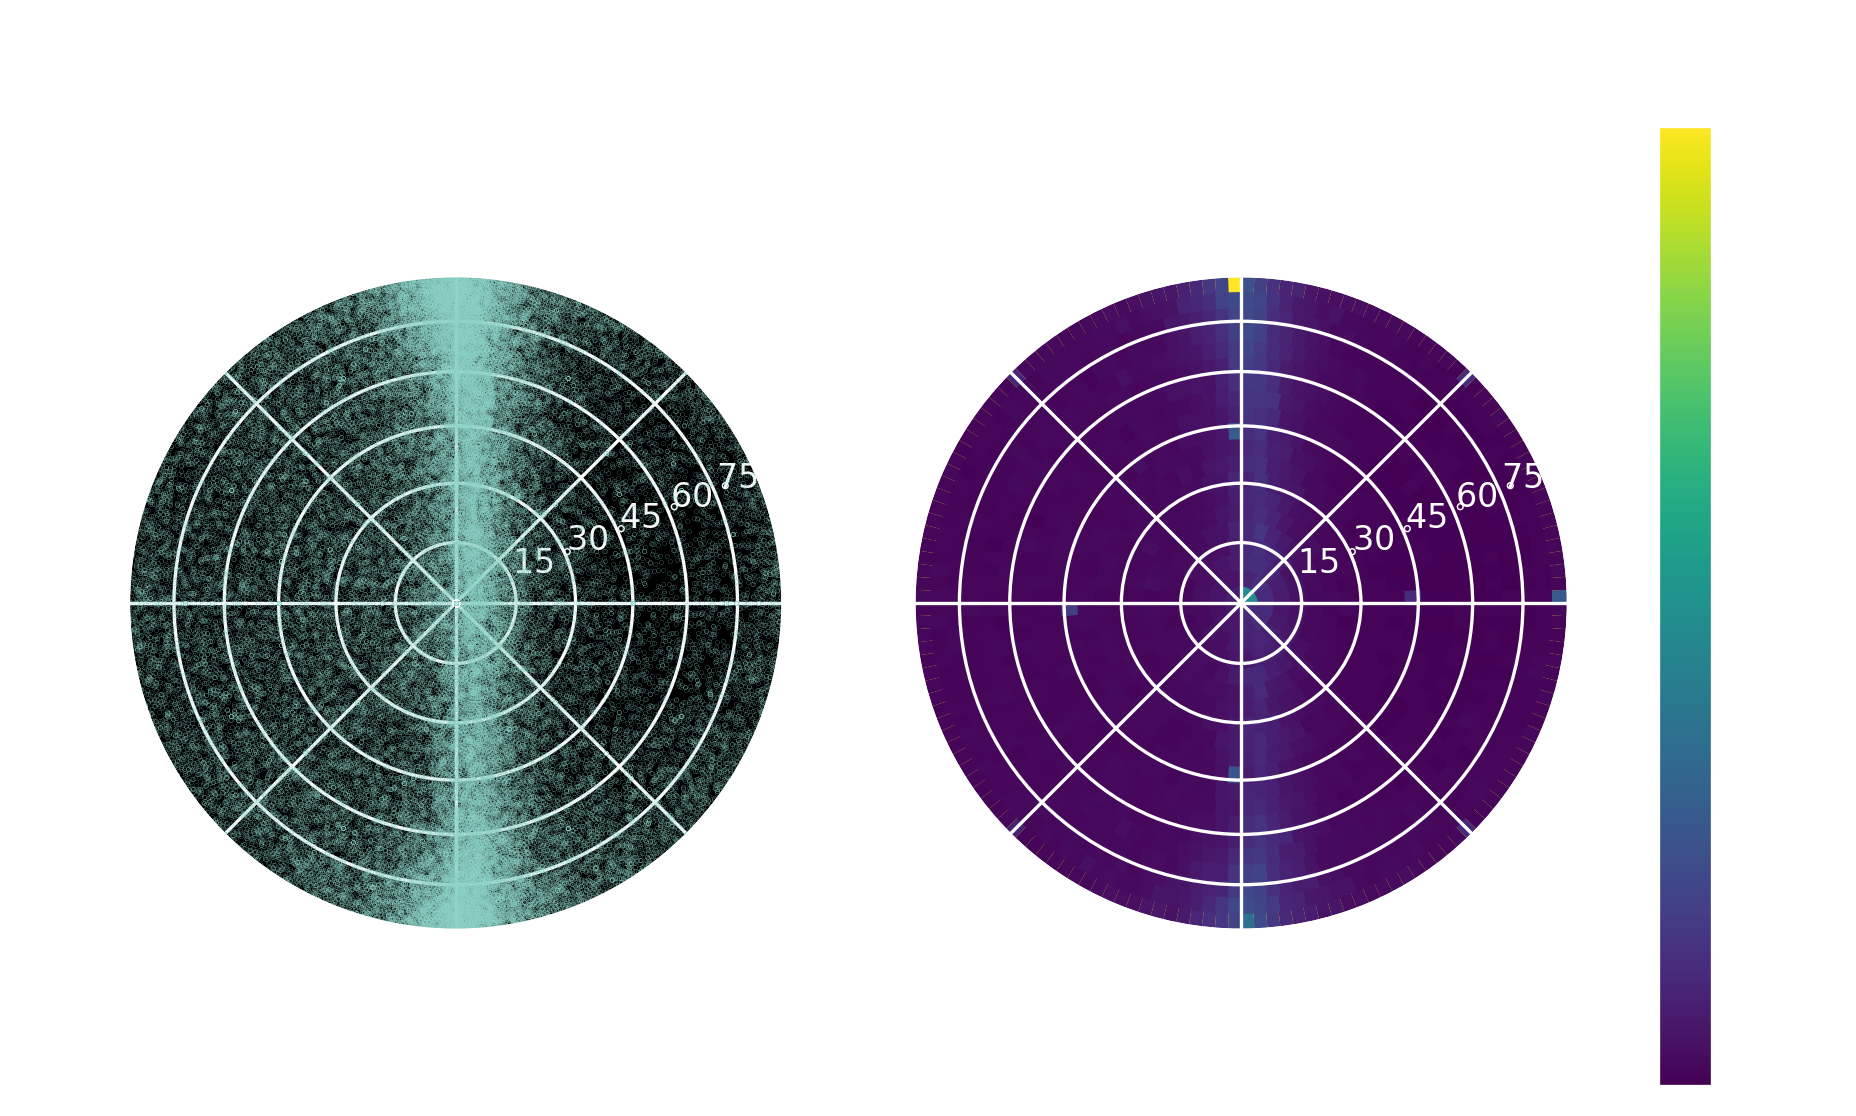

In [17]:
spam.plotting.orientationPlotter.plotOrientations(MOIeigenVectors[np.where(MOIeigenVectors[:, 3:6].any(axis=1))[0], 3:6], plot='both', numberOfRings=20, pointMarkerSize=0.1, title='evec 2', cmap=cmap) # evec 2

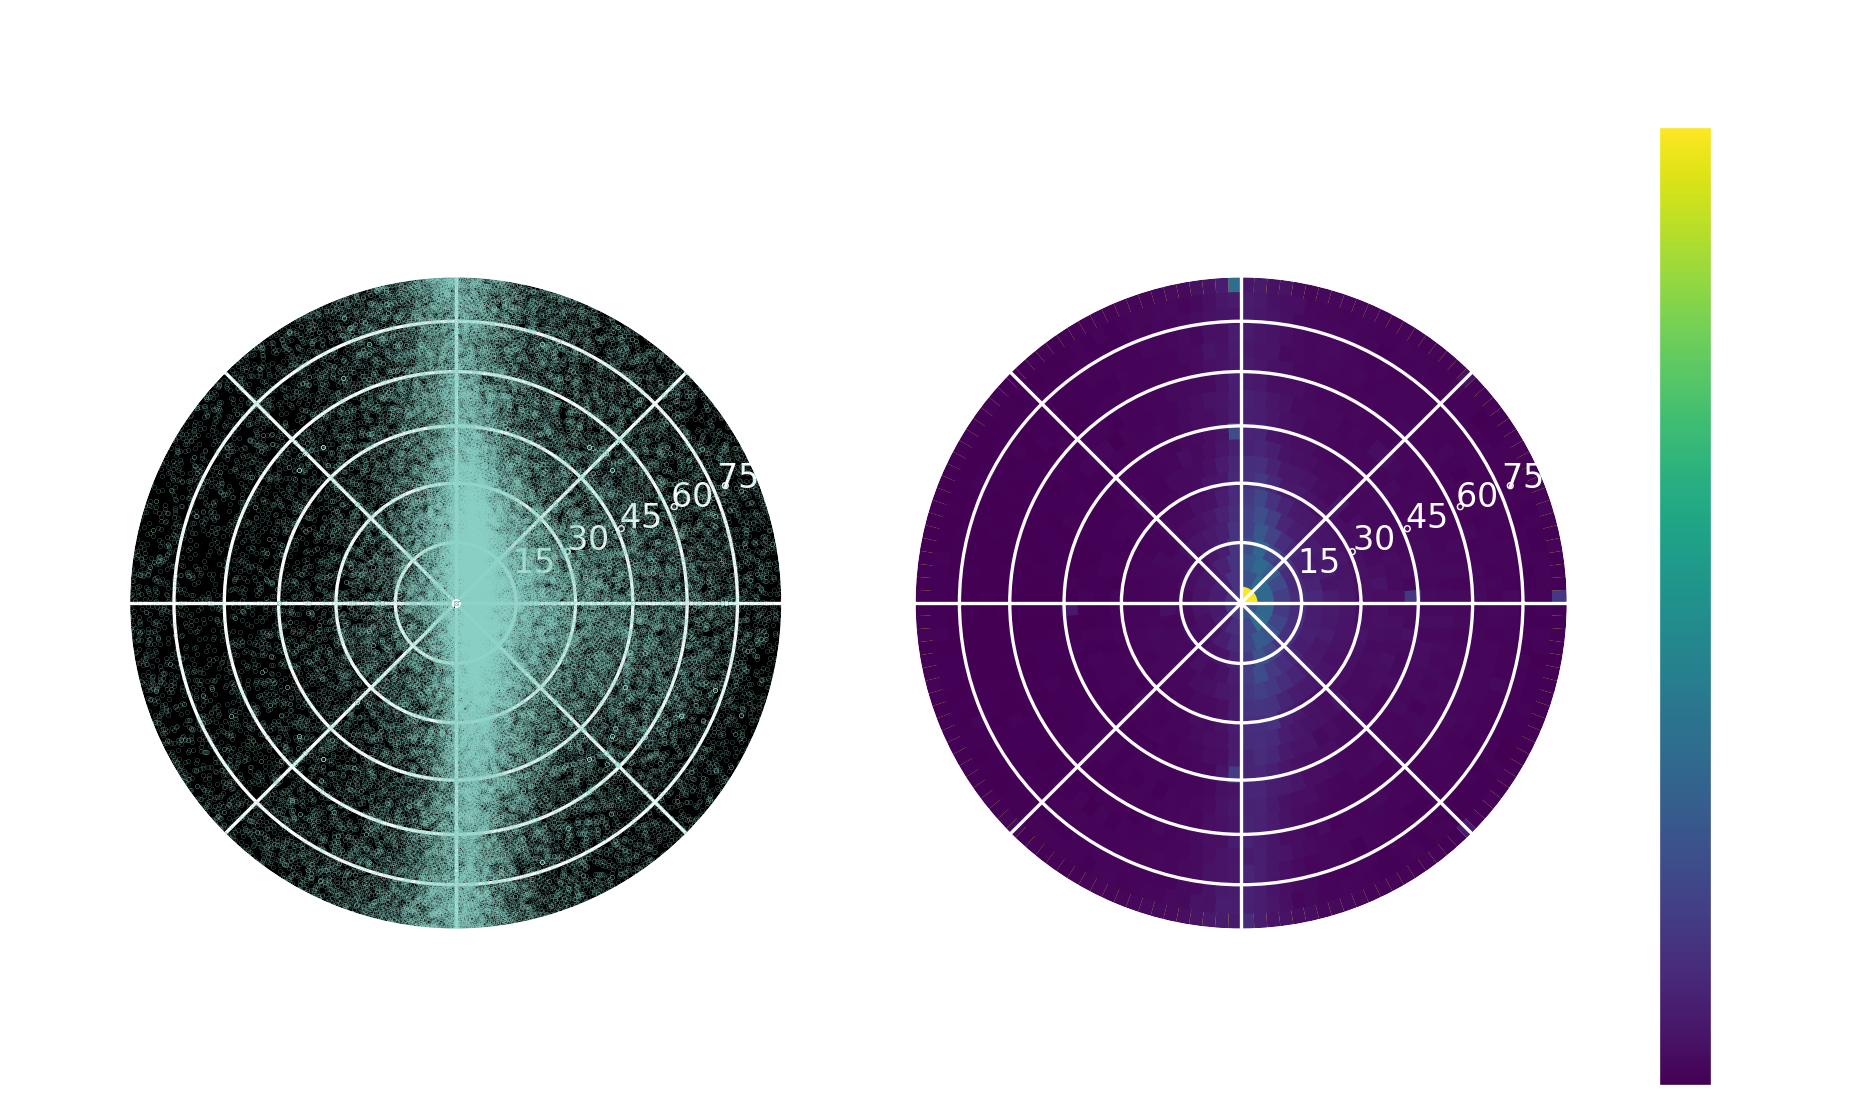

In [18]:
spam.plotting.orientationPlotter.plotOrientations(MOIeigenVectors[np.where(MOIeigenVectors[:, 6:9].any(axis=1))[0], 6:9], plot='both', numberOfRings=20, pointMarkerSize=0.1, title='evec 3', cmap=cmap) # evec 3

There is a strong preferential alingment of the particles along the Z-Y plane.

## Save vector filed data of particle orientation
We use `meshio` to save an `unstructured grid` `VTK` file containing the coordinates of each particle's center of mass and its orientation vector.
This file can be loaded and visualized in paraview:
<!-- ![pearls orientation](100slices_regions_orientation.png) -->
![pearls orientation](crystals_orientation_bg.png)

The coordinates [x,y,z] of the particle's center of mass are stored in the array: `centresOfMass[1:, [2, 1, 0]]`.
The particle's orientation vector [x,y,z] is in `MOIeigenVectors[1:, [8, 7, 6]]`.

In [68]:
meshio.write_points_cells(work_folder+"/crystals_orientation.vtk",
                          centresOfMass[1:, [2, 1, 0]], [],
                          point_data={"MOIeigenVector1": MOIeigenVectors[1:, [2, 1, 0]],
                                      "MOIeigenVector2": MOIeigenVectors[1:, [5, 4, 3]],
                                      "MOIeigenVector3": MOIeigenVectors[1:, [8, 7, 6]],
                                      "projection_phi": projection_theta_r[:, 0],
                                      "projection_theta": projection_theta_r[:, 1],
                                      "anisotropy": DA,
                                      "theta": theta,
                                      "sphericity": sphericity[1:].astype('float'),
                                      "volumes": pearl_volume[1:].astype('int')})

In [1]:
import h5py

In [67]:
MOIeigenValues.dtype

dtype('float32')

In [74]:
with h5py.File(res_folder+"/581681_punta_HR_stitch2_crystals_results_230221.hdf5", "w") as f:
    g_spam = f.create_group("spam")
    g_spam.create_dataset("volume", data=pearl_volume, dtype='uint32', compression="gzip")
    g_spam.create_dataset("sphericity", data=sphericity.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("MOIeigenValues", data=MOIeigenValues.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("MOIeigenVectors", data=MOIeigenVectors.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("DA", data=DA.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("centresOfMass", data=centresOfMass.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("projection_theta_r", data=projection_theta_r.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("theta", data=theta.astype('float16'), dtype='float16', compression="gzip")
    
    g_location = f.create_group("particle_location")
    g_location.create_dataset("dist_particle-pitfront", data=distances_pit_bottom.astype('float16'), dtype='float16', compression="gzip")
    g_location.create_dataset("dist_particle-void", data=distances_voids.astype('float16'), dtype='float16', compression="gzip")
    g_location.create_dataset("dist_void-pitfront", data=voids_dist_front.astype('float16'), dtype='float16', compression="gzip")

---
**To do:**
- [X] add DA scalar field
- [ ] display in Paraview scaling and coloring by DA
- [X] display in Paraview coloring by orientation angle with respect to X (0-90 deg)
- [ ] Generate table of the particle centroids and first eigenvector components.

---
# Dependencies

In [1]:
import watermark

In [ ]:
%load_ext watermark

%watermark
%watermark --iversions

---
# Acknowledgements
-  The authors acknowledge the [CERIC-ERIC](https://www.ceric-eric.eu/) Consortium for the access to experimental facilities and financial support